### Check the correct Python environment

In [1]:
import sys
print(sys.executable)

C:\Users\akmnuhilmehdy\AppData\Local\Continuum\anaconda3\envs\nlp\python.exe


### Package Importing

In [2]:
from os import listdir
import random
from pathlib import Path
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

import spacy
from spacy import displacy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Input
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

C:\Users\akmnuhilmehdy\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
nlp = spacy.load('en_core_web_sm')

### Train the Spacy Entity Recognizer Model for more entities 
Annotation of Custom Entity

In [10]:
# Helper Function

# text = 'My son is in depression because of his grades'
# look = 'depression'
# if text.find(look) != -1:    
#     start = text.find(look)
#     end = text.find(look)+len(look)

# print(start, end, text[start:end])

# I have the flu
# I got a fever
# He was identified as diabetic positive after the blood test
# My daughter is having severe toothache 
# Heart disease is what I was afraid of and eventually got that
# My son is in depression because of his grades

**Train and Save the Custom Model**

In [12]:
# new entity label
LABEL = 'HEALTH'

# training data
# Note: If you're using an existing model, make sure to mix in examples of
# other entity types that spaCy correctly recognized before. Otherwise, your
# model might learn the new type, but "forget" what it previously knew.
# https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting
TRAIN_DATA = [    
    ("I got flu.", {
        'entities': [(6, 9, 'HEALTH')]
    }),
    ("He has the flu.", {
        'entities': [(7, 14, 'HEALTH')]
    }),    
    ("He is sick.", {
        'entities': [(6, 10, 'HEALTH')]
    }),    
    ("I got a fever", {
        'entities': [(8, 13, 'HEALTH'), (6, 13, 'HEALTH')]
    }),        
    ("He was identified as diabetic positive after the blood test", {
        'entities': [(21, 29, 'HEALTH'), (49, 59, 'HEALTH'), (45, 59, 'HEALTH')]
    }),            
    ("My daughter is having severe toothache", {
        'entities': [(29, 38, 'HEALTH')]
    }),   
    ("Heart disease is what I was afraid of and eventually got that", {
        'entities': [(0, 13, 'HEALTH'), (6, 13, 'HEALTH')]
    }),       
    ("My son is in depression because of his grades", {
        'entities': [(13, 23, 'HEALTH')]
    }),    
    ('Who is Shaka Khan?', {
        'entities': [(7, 17, 'PERSON')]
    }),    
]


# @plac.annotations(
#     model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
#     new_model_name=("New model name for model meta.", "option", "nm", str),
#     output_dir=("Optional output directory", "option", "o", Path),
#     n_iter=("Number of training iterations", "option", "n", int))
def add_new_dre(model=None, new_model_name='custom_model', output_dir=None, n_iter=20):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.load('en_core_web_sm')  # create blank Language class
        print("Created blank 'en' model")

    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe('ner')

    ner.add_label(LABEL)   # add new entity label to entity recognizer

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update([text], [annotations], sgd=optimizer, drop=0.35,
                           losses=losses)
            print(losses)

    # test the trained model
    test_text = 'He has the flu. Andrew got flu. I lost $10 bucks.'
    doc = nlp(test_text)
    print("Entities in '%s'" % test_text)
    for ent in doc.ents:
        print(ent.label_, ent.text)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta['name'] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)


add_new_dre('en_core_web_sm', 'custom_model', 'model')

Loaded model 'en_core_web_sm'
{'ner': 34.46106240329208}
{'ner': 25.473342744453756}
{'ner': 28.799127465248507}
{'ner': 31.654471527882777}
{'ner': 21.50484825572408}
{'ner': 26.33918689832444}
{'ner': 29.770518154590732}
{'ner': 23.797793559826243}
{'ner': 20.719195279293213}
{'ner': 20.894630552758617}
{'ner': 17.97202802839874}
{'ner': 17.9460092577383}
{'ner': 19.069500896687842}
{'ner': 23.30363188303404}
{'ner': 11.478488287446982}
{'ner': 13.532128093762752}
{'ner': 15.97838783006197}
{'ner': 21.987807338130118}
{'ner': 16.986477279289748}
{'ner': 18.123693019106106}
Entities in 'He has the flu. Andrew got flu. I lost $10 bucks.'
HEALTH the flu
Saved model to model
Loading from model
HEALTH the flu


**Checking the Newly Trained Entity Recogniser**

In [16]:
nlp = spacy.load('model')
doc = nlp(u'I have the flu. I have $1000 loan. Shaka Khan is sick. He was identified as diabetic positive after the blood test.')
displacy.render(doc, style='ent', jupyter=True)

In [17]:
doc = nlp(u'I got the flu. My daughter is having severe toothache.')
displacy.render(doc, style='ent', jupyter=True)

In [18]:
number_of_data_in_each_class = 5000

# Remaining is the test dataset
train_with_percentage = 60 

split_file_at = int(number_of_data_in_each_class*(train_with_percentage/100))-1
train_untill = split_file_at
test_from = train_untill+1

print("Split files at: ", split_file_at)
print("Train Until: 0 -", train_untill)
print("Test From: ", test_from, "-", number_of_data_in_each_class-1)

Split files at:  2999
Train Until: 0 - 2999
Test From:  3000 - 4999


In [19]:
PERSONS = ['I', 'ME', 'MY', 'MINE', 'YOU', 'YOUR', 'YOURS', 'HE', 'SHE', 
           'HIS', 'HER', 'HIM', 'THEY', 'THEM', 'THEMSELVES', 'OUR', 'WE']
LOCATION = ['LOC', 'GPE', 'ORG', 'FAC', 'CARDINAL']
ALL_ENTITIES = LOCATION + ['PERSON', 'HEALTH', 'MONEY', 'DATE', 'TIME']

**Getting Boundary and Different Representations in Between that**

In [20]:
def modify_sentence(sen):
    doc = nlp(u''+sen)

    modified_tokens = []
    modified_tokens_dep = []
    modified_tokens_pos = []
        
    for t in doc:
        if t.ent_type_ == '':
            if t.text.upper() in PERSONS:
                modified_tokens.append('PERSON')
            else:
                modified_tokens.append(t.text)
        else:
            modified_tokens.append(t.ent_type_)
            
#     print(modified_tokens, len(modified_tokens))
    
    for t in doc:
        modified_tokens_dep.append(t.dep_)

#     print(modified_tokens_dep, len(modified_tokens_dep))
    
    
    for t in doc:
        modified_tokens_pos.append(t.pos_)
        
#     print(modified_tokens_pos, len(modified_tokens_pos))
            
    sen_length = len(modified_tokens)

    i = 0   
    start = 0
    for token in modified_tokens:
        if token.upper() in ALL_ENTITIES:
            start = i
            break

        i = i+1

    j = 0
    end = None
    for token in list(reversed(modified_tokens)):
        if token.upper() in ALL_ENTITIES:
            end = j
            break

        j = j+1

    end = (sen_length - (end)) if end != None else 0    

    return start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos

**Testing pre-processing**

In [21]:
sentence = 'Ok, I will meet you in Starbucks at 7pm sharp'
start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(sentence)

print(modified_tokens[start: end])
print(modified_tokens_dep[start: end])
print(modified_tokens_pos[start: end])

['PERSON', 'will', 'meet', 'PERSON', 'in', 'GPE']
['nsubj', 'aux', 'ROOT', 'dobj', 'prep', 'pobj']
['PRON', 'VERB', 'VERB', 'PRON', 'ADP', 'PROPN']


**Prepare the Vocabulary**

In [27]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


# load a doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    doc = load_doc(filename)
    
    start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(doc)
    
    # print(modified_tokens)
    vocab.update(modified_tokens)
    
    # print(modified_tokens_dep)    
    vocab.update(modified_tokens_dep)
    
    # print(modified_tokens_pos)    
    vocab.update(modified_tokens_pos)    
    
    # print('-'*50)
    
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    # walk through all files in the folder
    i = 0
    for filename in sorted(listdir(directory)):
        print(i)
        if not filename.endswith(".txt"):
            continue

        # skip any posts in the train set
        # skip any posts in the test set
        file_number = int(filename[:5])
        if is_trian and file_number > train_untill:
            continue
                            
        if not is_trian and file_number < test_from:
            continue               
            
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)
        i += 1
        
        
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('data/non_disclosure', vocab, True)
process_docs('data/disclosure', vocab, True)

# print the size of the vocab
print("Vocabulary length: ", len(vocab))
# print the top words in the vocab
print("Top 100 vocabulary with count: ", vocab.most_common(100))        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446


1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


Top 100 vocabulary with count:  [('VERB', 22676), ('NOUN', 17588), ('PERSON', 12357), ('nsubj', 12173), ('PRON', 11325), ('ADJ', 10499), ('ADP', 10238), ('ADV', 9372), ('prep', 7781), ('DET', 7778), ('advmod', 7662), ('ROOT', 7204), ('pobj', 7163), ('det', 6758), ('dobj', 5985), ('aux', 5873), ('conj', 4963), ('CCONJ', 4687), ('cc', 4668), ('amod', 4245), ('PUNCT', 3963), ('punct', 3727), (',', 3313), ('and', 3116), ('HEALTH', 2923), ('poss', 2777), ('PART', 2763), ('ccomp', 2751), ('to', 2735), ('compound', 2311), ('advcl', 2123), ('acomp', 2109), ('PROPN', 1942), ('mark', 1906), ('a', 1752), ('the', 1638), ('xcomp', 1636), ('neg', 1594), ('DATE', 1552), ('NUM', 1294), ('of', 1294), ('it', 1260), ('attr', 1219), ('was', 1161), ('is', 1117), ('in', 1105), ('relcl', 1062), ('that', 1044), ('nummod', 996), ('npadvmod', 944), ('have', 916), ('for', 887), ('with', 844), ('but', 788), ("n't", 728), ('prt', 710), ('do', 689), ('not', 633), ('on', 624), ('pcomp', 620), ("'", 610), ('auxpass',

In [28]:
# keep tokens with a min occurrence
min_occurane = 1
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print("Tokens that appeared at least once: ", len(tokens))

def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'data/vocab/vocab.txt')

Tokens that appeared at least once:  9268


In [34]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab, modify_type=None):
    
    # To Do: Check from Saved Vocab
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_trian, modify_type=None):
    documents = list()
    documents_dep = list()    
    documents_pos = list()   
    
    i = 0
    # walk through all files in the folder
    for filename in sorted(listdir(directory)):
        print(i)
        if not filename.endswith(".txt"):
            continue        
            
        # skip any posts in the test set
        file_number = int(filename[:5])
        if is_trian and file_number > train_untill:
            continue
                            
        if not is_trian and file_number < test_from:
            continue                        
            
        # create the full path of the file to open
        path = directory + '/' + filename
        
        # load the doc            
        doc = load_doc(path)
        start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(doc)
        
        # clean doc
        if modify_type == 'dep':        
            mod_sentence = ' '.join(modified_tokens_dep[start:end])
            # print(mod_sentence)
            documents_dep.append(mod_sentence)
        elif modify_type == 'pos':      
            mod_sentence = ' '.join(modified_tokens_pos[start:end])
            # print(mod_sentence)
            documents_pos.append(mod_sentence)            
        else:    
            mod_sentence = ' '.join(modified_tokens[start:end])
            # print(mod_sentence)
            documents.append(mod_sentence)
        i += 1
            
    if modify_type == 'dep':
        return documents_dep
    elif modify_type == 'pos':
        return documents_pos        
    else:    
        return documents

In [35]:
# load the vocabulary
vocab_filename = 'data/vocab/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
print("Total vocabulary: ", len(vocab))

Total vocabulary:  9265


**Traning Data in Different Representation**

In [36]:
positive_docs = process_docs('data/disclosure', vocab, True)
negative_docs = process_docs('data/non_disclosure', vocab, True)
train_docs = negative_docs + positive_docs
print(train_docs, len(train_docs), '\n')

positive_docs_dep = process_docs('data/disclosure', vocab, True, 'dep')
negative_docs_dep = process_docs('data/non_disclosure', vocab, True, 'dep')
train_docs_dep = negative_docs_dep + positive_docs_dep
print(train_docs_dep, len(train_docs_dep), '\n')

positive_docs_pos = process_docs('data/disclosure', vocab, True, 'pos')
negative_docs_pos = process_docs('data/non_disclosure', vocab, True, 'pos')
train_docs_pos = negative_docs_pos + positive_docs_pos
print(train_docs_pos, len(train_docs_pos), '\n')

all_docs_in_dif_rep = train_docs + train_docs_dep + train_docs_pos
# print(all_docs_in_dif_rep, len(all_docs_in_dif_rep), '\n')

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(all_docs_in_dif_rep)

# sequence encode
# To Do: Check Different Encoding Scope
# encoded_docs = tokenizer.texts_to_sequences(train_docs)
encoded_docs = tokenizer.texts_to_sequences(all_docs_in_dif_rep)
print(encoded_docs, len(encoded_docs))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447


1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


['PERSON', '', 'CARDINAL towels and washclothes for a room with CARDINAL', 'PERSON', 'DATE DATE DATE HEALTH HEALTH HEALTH', '', '', 'PERSON are still around each other all of HEALTH HEALTH', '', '', 'HEALTH HEALTH of cooking , PERSON add some olive oil and this makes a wonderful side HEALTH', '', '', 'PERSON', 'HEALTH HEALTH', '', 'PERSON PERSON', "PERSON mother 's birthday , HEALTH HEALTH of CARDINAL", 'TIME TIME', 'PERSON PERSON', 'HEALTH HEALTH 3 separations this was what PERSON', '', '', 'PERSON', '', 'HEALTH HEALTH room , a load of cnts PERSON', 'HEALTH HEALTH was PERSON', 'PERSON believe during that time', '', 'PERSON', '', '', 'HEALTH HEALTH', '', '', 'PERSON have already taken CARDINAL', 'PERSON have screwed myself as HEALTH HEALTH', 'PERSON PERSON', '', 'PERSON', 'PERSON will definitely considering booking another stay when in HEALTH HEALTH', 'PERSON was single with CARDINAL', '', 'PERSON', 'PERSON', 'PERSON', '', '', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON',

6000 

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444


1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


['nsubj', '', 'nummod dobj cc conj prep det pobj prep nummod', 'nsubj', 'det amod ROOT det relcl cc', '', '', 'nsubj ROOT advmod prep det pobj pobj prep det pobj', '', '', 'det pobj prep pobj punct nsubj ROOT det amod dobj cc nsubj conj det amod nsubj advmod', '', '', 'nsubj', 'det pobj', '', 'compound nsubj', 'poss poss case attr punct det nsubj prep nummod', 'nummod nsubj', 'compound dobj', 'det amod nummod pobj nsubj ROOT dobj nsubj', '', '', 'nsubj', '', 'det amod pobj punct det ROOT prep pobj nsubj', 'det nsubj ROOT attr', 'nsubj relcl prep det pobj', '', 'nsubj', '', '', 'det dobj', '', '', 'nsubj aux advmod ROOT nummod', 'nsubj aux ROOT dobj prep det pobj', 'compound compound', '', 'nsubj', 'nsubj aux advmod ROOT xcomp det dobj advmod advcl det pobj', 'nsubj relcl acomp prep nummod', '', 'poss', 'nsubj', 'nsubj', '', '', 'nsubj', 'nsubj', 'nsubjpass', 'nsubj', 'nsubj', 'poss', 'nsubj', '', 'nsubj ROOT det amod dobj cc nsubj conj amod amod compound dobj prep det pobj', 'nsubj', '

6000 

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444


1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193


3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


['PRON', '', 'NUM NOUN CCONJ NOUN ADP DET NOUN ADP NUM', 'PRON', 'DET ADJ NOUN DET NOUN CCONJ', '', '', 'PRON VERB ADV ADP DET ADJ DET ADP DET NOUN', '', '', 'DET NOUN ADP NOUN PUNCT PRON VERB DET ADJ NOUN CCONJ DET VERB DET ADJ NOUN ADV', '', '', 'PRON', 'DET NOUN', '', 'VERB PROPN', 'ADJ NOUN PART NOUN PUNCT DET NOUN ADP NUM', 'NUM NOUN', 'PROPN PROPN', 'DET ADJ NUM NOUN DET VERB NOUN PRON', '', '', 'PRON', '', 'DET ADJ NOUN PUNCT DET NOUN ADP NOUN PRON', 'DET NOUN VERB ADJ', 'PRON VERB ADP DET NOUN', '', 'PRON', '', '', 'DET NOUN', '', '', 'PRON VERB ADV VERB NUM', 'PRON VERB VERB PRON ADP DET NOUN', 'PROPN PROPN', '', 'PRON', 'PRON VERB ADV VERB VERB DET NOUN ADV ADP DET NOUN', 'PRON VERB ADJ ADP NUM', '', 'ADJ', 'PRON', 'PRON', '', '', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', '', 'PRON VERB DET ADJ NOUN CCONJ PRON VERB NOUN ADJ NOUN NOUN ADP DET NOUN', 'PRON', 'ADJ NOUN', 'PRON', 'PRON', 'PRON', 'PRON', '', 'PROPN PROPN ADJ PROPN', 'PRON VERB DET NOUN', '', 'ADJ ADJ

6000 



[[2], [], [54, 1015, 23, 2332, 48, 36, 186, 50, 54], [2], [27, 27, 27, 17, 17, 17], [], [], [2, 85, 150, 166, 328, 189, 86, 39, 17, 17], [], [], [17, 17, 39, 1597, 2, 400, 143, 2333, 880, 23, 72, 258, 36, 647, 329, 17], [], [], [2], [17, 17], [], [2, 2], [2, 226, 88, 788, 17, 17, 39, 54], [52, 52], [2, 2], [17, 17, 648, 2334, 72, 47, 83, 2], [], [], [2], [], [17, 17, 186, 36, 1252, 39, 2335, 2], [17, 17, 47, 2], [2, 232, 322, 42, 52], [], [2], [], [], [17, 17], [], [], [2, 45, 564, 323, 54], [2, 45, 1598, 131, 73, 17, 17], [2, 2], [], [2], [2, 104, 1016, 1599, 2336, 350, 214, 75, 41, 17, 17], [2, 47, 401, 50, 54], [], [2], [2], [2], [], [], [2], [2], [2], [2], [2], [2], [2], [], [2, 881, 17, 17, 2337, 23, 46, 384, 2338, 218, 2339, 2340, 41, 17, 17], [2], [17, 17], [2], [2], [2], [2], [], [2, 1017, 1253, 2], [2, 68, 17, 17], [], [2, 1600, 118, 402, 23, 242], [54], [], [2], [], [2], [2], [], [], [17, 17, 39, 54], [2], [2], [], [], [17, 17], [55, 882, 2341, 51, 1254, 41, 17, 17], [], [17,

18000


In [37]:
# pad sequences
# get the biggest post as per its contents
# max_length = max([len(s.split()) for s in train_docs])
max_length = max([len(s.split()) for s in all_docs_in_dif_rep])

# define training data
# Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtrain = pad_sequences(encoded_docs[:6000], maxlen=max_length, padding='post')
print("Total number of Training Data: ", len(Xtrain))


Xtrain_dep = pad_sequences(encoded_docs[6000:12000], maxlen=max_length, padding='post')
print("Total number of Training Data dep: ", len(Xtrain_dep))


Xtrain_pos = pad_sequences(encoded_docs[12000:18000], maxlen=max_length, padding='post')
print("Total number of Training Data pos: ", len(Xtrain_pos))

# define training labels
# put 0s for the first <split_file_at> entries and 1s for last <split_file_at> entries.
# Because, in the <train_docs> list we have the public docs first
# and private docs later.
# From now on we are assuming 0 for public data, 1 for private data
ytrain = np.array([0 for _ in range((train_untill+1))] + [1 for _ in range((train_untill+1))])
print("Total number of Training labels: ", len(ytrain))



Total number of Training Data:  6000
Total number of Training Data dep:  6000
Total number of Training Data pos:  6000
Total number of Training labels:  6000


**Test Data in Different Representation**

In [40]:
# load all test posts
positive_docs = process_docs('data/disclosure', vocab, False)
negative_docs = process_docs('data/non_disclosure', vocab, False)
test_docs = negative_docs + positive_docs
print(test_docs, len(test_docs), '\n')

positive_docs_dep = process_docs('data/disclosure', vocab, False, 'dep')
negative_docs_dep = process_docs('data/non_disclosure', vocab, False, 'dep')
test_docs_dep = negative_docs_dep + positive_docs_dep
print(test_docs_dep, len(test_docs_dep), '\n')

positive_docs_pos = process_docs('data/disclosure', vocab, False, 'pos')
negative_docs_pos = process_docs('data/non_disclosure', vocab, False, 'pos')
test_docs_pos = negative_docs_pos + positive_docs_pos
print(test_docs_pos, len(test_docs_pos), '\n')

all_test_docs_in_dif_rep = test_docs + test_docs_dep + test_docs_pos

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(all_test_docs_in_dif_rep)
# pad sequences
# Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtest = pad_sequences(encoded_docs[:4000], maxlen=max_length, padding='post')

Xtest_dep = pad_sequences(encoded_docs[4000:8000], maxlen=max_length, padding='post')

Xtest_pos = pad_sequences(encoded_docs[8000:12000], maxlen=max_length, padding='post')

# define test labels
ytest = np.array([0 for _ in range((number_of_data_in_each_class - test_from))] + [1 for _ in range((number_of_data_in_each_class - test_from))])
print("Total number of Test labels: ", len(ytest))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
11

['PERSON', 'PERSON PERSON des ORG', 'PERSON gave it CARDINAL', 'HEALTH HEALTH', "PERSON did n't use HEALTH HEALTH", 'PERSON', 'PERSON', 'PERSON', 'PERSON', '', 'PERSON', 'PERSON', '', 'PERSON', '', '', 'PERSON', 'ORG box was intact , so it had to be either from the PERSON PERSON people or the ORG', 'PERSON', 'PERSON', 'PERSON', 'PERSON', '', 'DATE DATE DATE DATE', '', '', 'PERSON role in anything CARDINAL', 'HEALTH HEALTH is what PERSON', '', 'HEALTH HEALTH', '', 'PERSON get a pretty big box , filled with CARDINAL', 'HEALTH HEALTH', 'CARDINAL', 'PERSON PERSON PERSON is a fun , unique gift for those tired of PERSON', 'ORG', 'PERSON', '', '', '', 'PERSON', 'PERSON', 'PERSON', '', 'DATE DATE DATE', 'PERSON', 'HEALTH HEALTH', 'PERSON', '', 'PERSON', 'PERSON', 'PERSON', '', 'PERSON', '', 'PERSON have friends of HEALTH HEALTH whose CARDINAL', 'PERSON gladly moved us and HEALTH HEALTH HEALTH', '', 'PERSON', '', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON PERS

4000 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156

['nsubj', 'compound compound nmod nsubj', 'nsubj ccomp dative nummod', 'det nsubj', 'nsubj aux neg ROOT det compound', 'nsubj', 'dobj', 'poss', 'nsubj', '', 'dobj', 'dobj', '', 'nsubj', '', '', 'nsubj', 'compound nsubj ROOT acomp punct intj nsubj conj aux xcomp preconj prep det compound compound pobj cc det compound', 'nsubj', 'nsubj', 'nsubj', 'nsubj', '', 'advmod nummod npadvmod advmod', '', '', 'poss dobj prep pobj nummod', 'det nsubj ROOT dobj nsubj', '', 'det amod', '', 'nsubj ROOT det advmod amod dobj punct advcl prep nummod', 'det conj', 'pobj', 'compound compound nsubj ROOT det amod punct amod attr prep det pobj prep pobj', 'prep', 'nsubj', '', '', '', 'nsubj', 'nsubj', 'poss', '', 'det nummod pobj', 'nsubj', 'det compound', 'nsubj', '', 'pobj', 'nsubj', 'nsubj', '', 'nsubj', '', 'nsubj ROOT dobj prep det pobj poss nummod', 'nsubj advmod ROOT dobj cc det amod nsubj', '', 'nsubjpass', '', 'nsubj', 'nsubj', 'nsubj', 'nsubj', 'poss', 'nsubj', 'nsubj', 'compound nsubj punct nsubj n

4000 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156

['PRON', 'PROPN PROPN X PROPN', 'PRON VERB PRON NUM', 'DET NOUN', 'PRON VERB ADV VERB DET NOUN', 'PRON', 'PRON', 'ADJ', 'PRON', '', 'PRON', 'PRON', '', 'PRON', '', '', 'PRON', 'PROPN NOUN VERB ADJ PUNCT CCONJ PRON VERB PART VERB CCONJ ADP DET PROPN PROPN NOUN CCONJ DET PROPN', 'PRON', 'PRON', 'PRON', 'PRON', '', 'ADV NUM NOUN ADV', '', '', 'ADJ NOUN ADP NOUN NUM', 'DET NOUN VERB NOUN PRON', '', 'DET ADJ', '', 'PRON VERB DET ADV ADJ NOUN PUNCT VERB ADP NUM', 'DET NOUN', 'NUM', 'PROPN PROPN PROPN VERB DET NOUN PUNCT ADJ NOUN ADP DET ADJ ADP PROPN', 'NOUN', 'PRON', '', '', '', 'PRON', 'PRON', 'ADJ', '', 'DET NUM NOUN', 'PRON', 'DET NOUN', 'PRON', '', 'PROPN', 'PRON', 'PRON', '', 'PRON', '', 'PRON VERB NOUN ADP DET NOUN ADJ NUM', 'PRON ADV VERB PRON CCONJ DET ADJ NOUN', '', 'PRON', '', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', 'PRON', 'PROPN PROPN PUNCT NOUN ADV ADJ VERB NOUN NOUN X PROPN NUM', '', '', 'PRON', 'DET NOUN', '', 'NOUN VERB DET ADJ', 'PRON', 'PRON', 'PRON', '', '', '', '

4000 

Total number of Test labels:  4000


In [41]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size (largest integer value): ", vocab_size)

Vocabulary size (largest integer value):  5518


### Using both CNN and LSTM
CNN will give the knowledge of spatial features to the LSTM as sequence

In [49]:
# model = Sequential()
# model.add(Embedding(vocab_size, 100, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit network
# model.fit(Xtrain, ytrain, epochs=20, verbose=2)

# # evaluate
# loss, acc = model.evaluate(Xtest, ytest, verbose=1)
# print('Test Accuracy: %f' % (acc*100))

### Using CNN Only with Dropout

In [50]:
# model = Sequential()
# model.add(Embedding(vocab_size, 32, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit network
# model.fit(Xtrain, ytrain, epochs=20, verbose=2)

# # evaluate
# loss, acc = model.evaluate(Xtest, ytest, verbose=1)
# print('Test Accuracy: %f' % (acc*100))

### Using Multichannel CNN

In [51]:
# fix random seed for reproducibility
np.random.seed(7)

# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding2)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)

# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
dense2 = Dense(10, activation='relu')(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel-cnn.png')


model.fit([Xtrain,Xtrain_dep,Xtrain_pos], ytrain, epochs=20, batch_size=50)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
input_15 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
embedding_13 (Embedding)         (None, 558, 100)      557100      input_13[0][0]                   
___________________________________________________________________________________________

In [52]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([Xtest,Xtest_dep,Xtest_pos], ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 93.725000


In [53]:
y_pred = model.predict([Xtest,Xtest_dep,Xtest_pos])

**ROC Curve for Multichannel CNN**

ROC Area Under Curve Score:  0.980527375


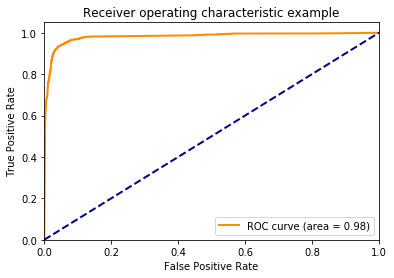

In [54]:
print("ROC Area Under Curve Score: ", roc_auc_score(ytest, y_pred))

fpr, tpr, _ = roc_curve(ytest[:], y_pred[:])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc.png')

**F1 Score for Multichannel CNN**

In [55]:
y_pred = y_pred.reshape(len(y_pred)).round()

# print(y_pred)
# print(ytest)

f1_bin = f1_score(ytest, y_pred, average='binary')
print("F1 Score for Disclosure Label: ", f1_bin)

f1_none = f1_score(ytest, y_pred, average=None)
print("F1 Score for Disclosure Label: ", f1_none[1])
print("F1 Score for Non-disclosure Label: ", f1_none[0])

f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score Weighted: ", f1_weighted)

F1 Score for Disclosure Label:  0.939092453288
F1 Score for Disclosure Label:  0.939092453288
F1 Score for Non-disclosure Label:  0.935292601186
F1 Score Weighted:  0.937192527237


### Using Multichannel LSTM Network

In [56]:
# fix random seed for reproducibility
np.random.seed(10)

# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
lstm1 = LSTM(100, dropout=0.2)(embedding1)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
lstm2 = LSTM(100, dropout=0.2)(embedding2)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
lstm3 = LSTM(100, dropout=0.2)(embedding3)

# merge
merged = concatenate([lstm1, lstm2, lstm3])

# dropout
# dropped = Dropout(0.2)(merged)

# interpretation
dense = Dense(100, activation='relu')(merged)
dense = Dense(10, activation='relu')(dense)
outputs = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel-lstm.png')


# model.fit([Xtrain,Xtrain_dep,Xtrain_pos], ytrain, epochs=20, batch_size=50)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
input_17 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
input_18 (InputLayer)            (None, 558)           0                                            
____________________________________________________________________________________________________
embedding_16 (Embedding)         (None, 558, 100)      557100      input_16[0][0]                   
___________________________________________________________________________________________

In [57]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([Xtest,Xtest_dep,Xtest_pos], ytest, verbose=1)
print('Test Accuracy: %f' % (acc*100))

4000/4000 [==============================] - 172s   
Test Accuracy: 50.000000


In [58]:
y_pred = model.predict([Xtest,Xtest_dep,Xtest_pos])

**ROC Curve for Multichannel LSTM**

ROC Area Under Curve Score:  0.5


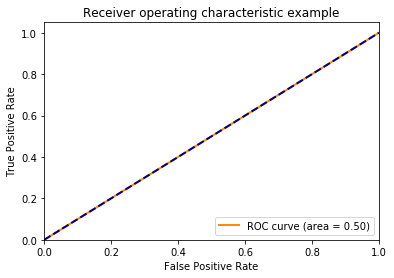

In [59]:
print("ROC Area Under Curve Score: ", roc_auc_score(ytest, y_pred))

fpr, tpr, _ = roc_curve(ytest[:], y_pred[:])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**F1 Score for Multichannel LSTM**

In [60]:
y_pred = y_pred.reshape(len(y_pred)).round()

# print(y_pred)
# print(ytest)

f1_bin = f1_score(ytest, y_pred, average='binary')
print("F1 Score for Disclosure Label: ", f1_bin)

f1_none = f1_score(ytest, y_pred, average=None)
print("F1 Score for Disclosure Label: ", f1_none[1])
print("F1 Score for Non-disclosure Label: ", f1_none[0])

f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score Weighted: ", f1_weighted)

F1 Score for Disclosure Label:  0.0
F1 Score for Disclosure Label:  0.0
F1 Score for Non-disclosure Label:  0.666666666667
F1 Score Weighted:  0.333333333333


/Users/nuhil/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nuhil/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
# val_f1 = f1_score(ytest, y_pred)
# val_recall = recall_score(val_targ, val_predict)
# val_precision = precision_score(val_targ, val_predict)